# Table of Contents
 <p>

In [1]:
import os
import pandas as pd
import numpy as np
import numba

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import matplotlib.dates as mdates

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


In [2]:
df = pd.read_excel('../input/viability_assay_combo.xlsx')
df['time'] = df.date.dt.strftime("%m-%d")
df.sort_values('time', inplace=True)

df = df[df.imcomplete != 'lost']

df['alive'] = df.d1_alive + df.d2_alive + df.d3_alive

In [3]:
df.head()

,gene,ID,d1_unhatched,d1_alive,d2_unhatched,d2_alive,d3_unhatched,d3_alive,total_unhatched(%),total_brood,not_an_outlier,date,N2 source,imcomplete,time,alive
86,N2,N2_32,1.0,59.0,0.0,130.0,0.0,38.0,0.0,228,True,2017-04-20,Shahla,n,04-20,227.0
85,N2,N2_31,0.0,58.0,0.0,145.0,0.0,59.0,0.0,262,True,2017-04-20,Shahla,n,04-20,262.0
83,N2,N2_29,0.0,48.0,0.0,117.0,0.0,40.0,0.0,205,True,2017-04-20,Shahla,n,04-20,205.0
82,N2,N2_28,0.0,50.0,0.0,95.0,0.0,89.0,0.0,234,True,2017-04-20,Shahla,n,04-20,234.0
81,N2,N2_27,0.0,48.0,0.0,102.0,0.0,22.0,0.0,172,True,2017-04-20,Shahla,n,04-20,172.0


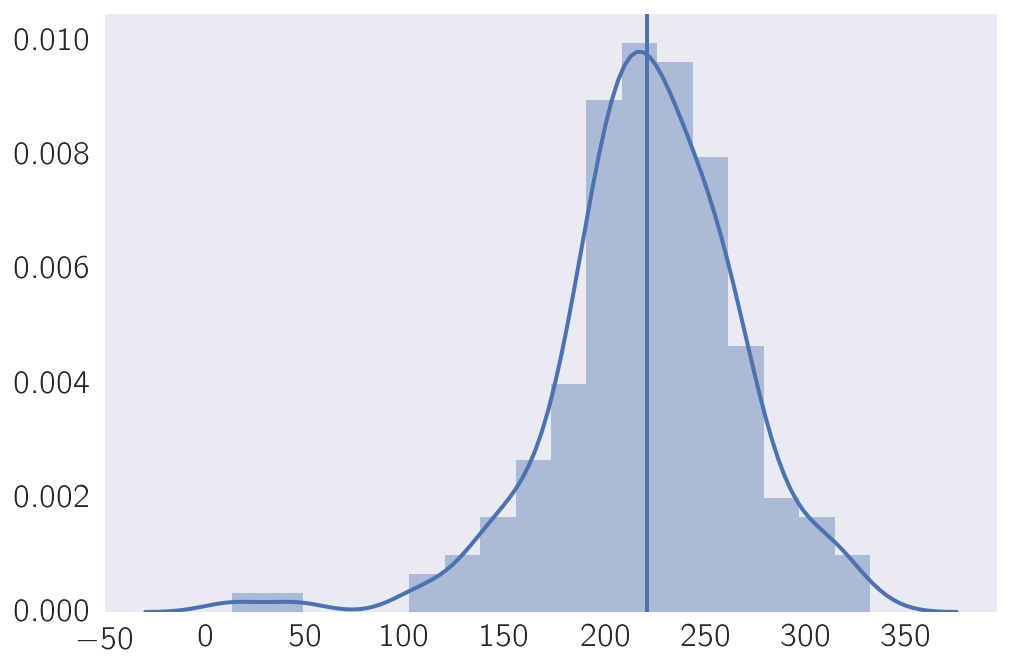

In [4]:
temp = df[df.gene == 'N2']

sns.distplot(temp.total_brood.values)
plt.axvline(temp.total_brood.mean())

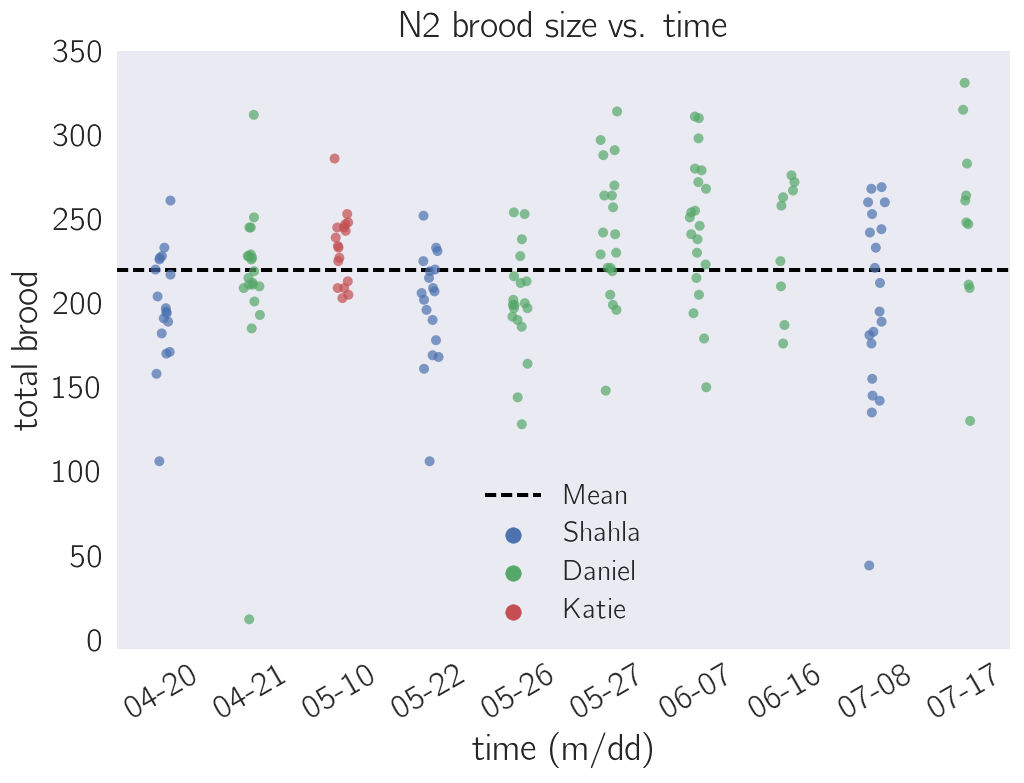

In [59]:
sns.stripplot(x='time', y='total_brood', hue='N2 source', data=temp, jitter=True, alpha=0.7)

plt.axhline(temp.total_brood.mean(), ls='--', zorder=0, color='k', label='Mean')
plt.ylabel('total brood')
plt.xticks(rotation=30)

plt.legend()

plt.xlabel('time (m/dd)')
plt.title('N2 brood size vs. time')

plt.savefig('../output/n2_thru_time.pdf', bbox_inches='tight')

In [60]:
def bootstrap(x, y, n, f=np.mean):
    """Given two dataset, generate a null distribution, resample and calculate the difference in test statistic f for each set."""
    nx = len(x)
    ny = len(y)
    
    mixed = np.zeros(nx + ny)
    mixed[0:nx] = x
    mixed[nx:] = y


    @numba.jit(nopython=True)
    def difference(x, y, n):
        """Given x and y, perform `n' bootstraps to calculate the null distribution of f(y) - f(x)."""
        delta = np.zeros(n)

        for i in np.arange(n):
            nullx = np.random.choice(mixed, nx, replace=True)
            nully = np.random.choice(mixed, ny, replace=True)

            diff = f(nully) - f(nullx)
            delta[i] = diff
        return delta
    
    delta = difference(x, y, n)

    return delta


def pval(x, y, n=10**5, f=np.mean):
    """Calculate a pvalue for the null hypothesis that f(x) = f(y)."""
    
    # this is a one-tailed test, so ensure it's the right tail!
    if f(y) > f(x):
        delta_obs = f(y) - f(x)
        delta = bootstrap(x, y, n, f)
    else:
        delta_obs = f(x) - f(y)
        delta = bootstrap(y, x, n, f)
    
    success = len(delta[(delta >= delta_obs)])
    pval = success/n
    return pval

the numbaized function is 50x faster than the naive function

In [76]:
grouped = df.groupby('gene')
control = df[df.gene == 'N2'].total_brood.values
ps = {}
ps['N2'] = 'control'

for name, group in grouped:
    if name == 'N2':
        continue

    p = pval(group.total_brood.values, control, n=10**6, f=np.median)
    if p < 0.01:
        print('{0}, pval: {1:.2g}'.format(name, p))
        ps[name] = 'sig'
    else:
        ps[name] = 'non-sig'

chd-7(36-24), pval: 0
chd-7(37-10), pval: 1e-06
chd-7(38-3), pval: 0.00015
cul-3(34-26), pval: 2.1e-05
daf-18(54-7), pval: 0.003
daf-18(57-7), pval: 0.00011
dlg-1(53-30), pval: 5e-06
lin-45(52-12), pval: 0
mpk-1(49-16), pval: 0.0021
mpk-1(SD464), pval: 0


In [72]:
df['sig'] = df.gene.map(ps)

(array([-20.,   0.,  20.,  40.,  60.]), <a list of 5 Text xticklabel objects>)

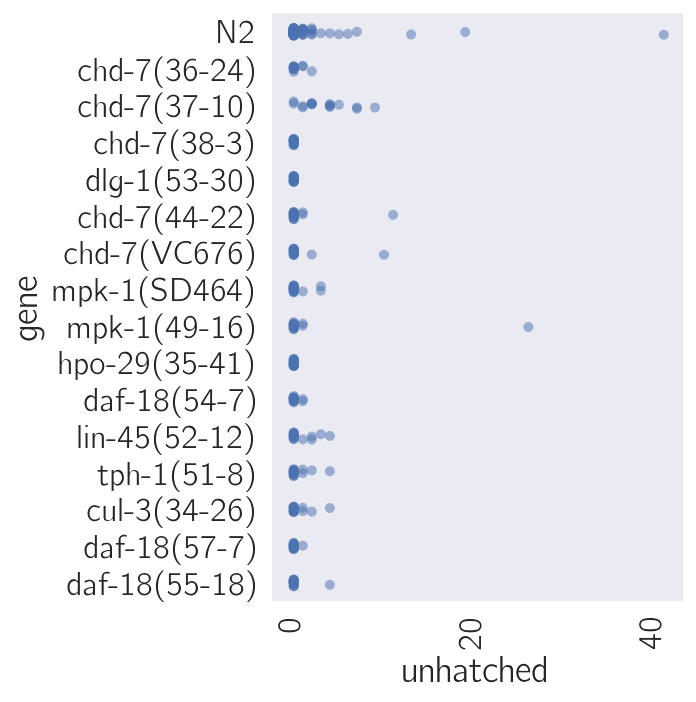

In [73]:
g = sns.FacetGrid(df, size=5)
g.map(sns.stripplot, r'unhatched', r'gene', alpha=0.5, jitter=True)
plt.xticks(rotation=90)

In [74]:
def jitterplot(df, x, y, by='gene', **kwargs):
    """Plot a stripplot ordered by the median value of each group."""
    xlabel = kwargs.pop('xlabel', 'total brood size')
    ylabel = kwargs.pop('ylabel', 'allele tested')

    # find grouped medians
    grouped = df.groupby(by)
    med = {}
    for name, group in grouped:
        med[name] = group.total_brood.median()
    
    # sort by median
    df2 = df.copy()
    df2['med'] = df2[by].map(med)
    df2.sort_values('med', inplace=True)
    
    fig, ax = plt.subplots()
    sns.stripplot(x=x, y=y, data=df2, **kwargs)
    plt.axvline(df2[df2.gene == 'N2'].total_brood.median(), ls='--', color='blue', lw=1, label='control median')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    ax.yaxis.grid(False)

    return fig, ax

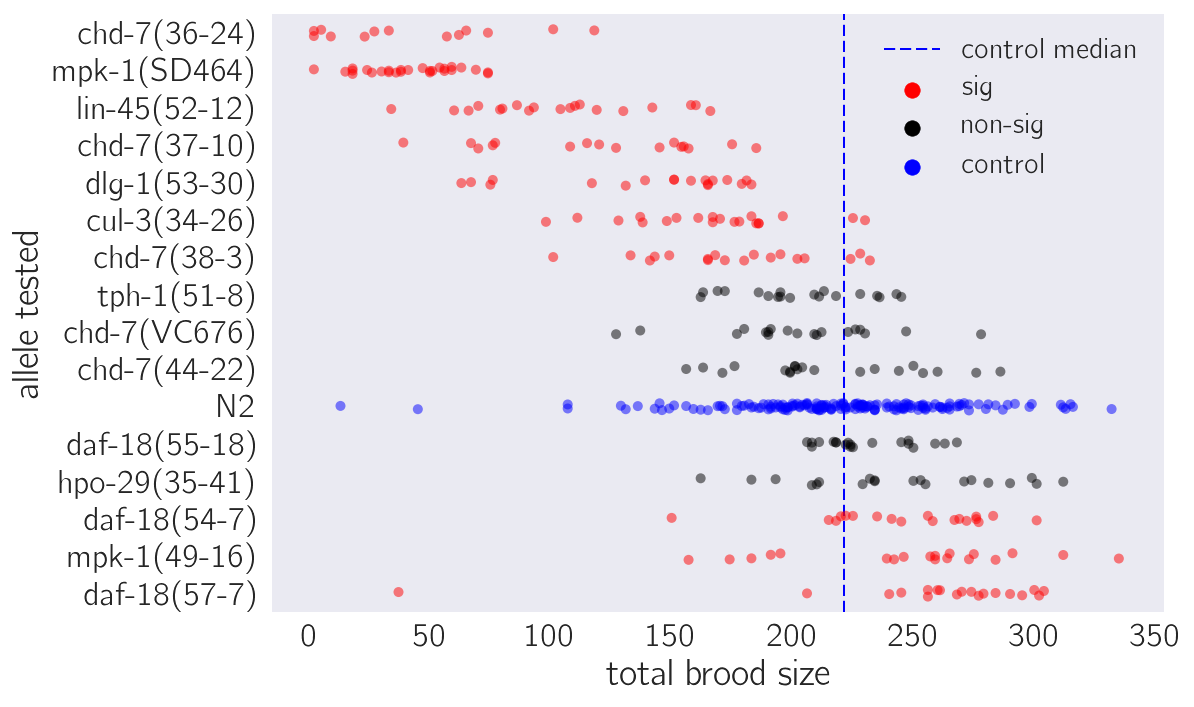

In [75]:
palette = {'sig': 'red', 'non-sig': 'black', 'control': 'blue'}

ax = jitterplot(df,'total_brood', 'gene', hue='sig', jitter=True, alpha=0.5, palette=palette)
plt.savefig('../output/brood_size.pdf', bbox_inches='tight')